In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from mlfinpy.labeling import add_vertical_barrier, get_events, get_bins
import mlfinpy as ml

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif

In [ ]:

y_label = "BSH"
threshold=0.005
vol_mult = 0.5



#RAW RETURNS LABELING
#Andiamo a utilizzare la volatiltà dei prezzi per valutare al meglio
#la soglia con cui etichettare le varie righe

def BSH_raw_returns(data):
    df = data.copy()
    df["Threshold"] = vol_mult * df["Return_std_20"]
    conditions = [
            df["Next_Return"] > df["Threshold"],
            df["Next_Return"] < -df["Threshold"]
    ]
    choices = ["BUY", "SELL"]

    df[y_label] = np.select(conditions, choices, default="HOLD")
    return df


#Criterio dietro alle etichette BUY / SELL / HOLD

# ----------------------------------------
# Condizioni iniziali, poi modificate per testare il dataset
# 
# Buy if (ema50 >= ema200) OR (Volume > VOLUME200)
# Sell if (RSI > 70 AND stoch_k > 80) OR (Close < ema50) OR (Close < ema200)
# Else Hold
# ----------------------------------------

def BSH_indices_labeling(row):
    # BUY:
    if (row["EMA50"] >= row["EMA200"] and 
        row["Volume"] > row["Vol_EMA200"]):  
        return "BUY"
    
    # SELL
    if ((row["RSI"] > 70 and row["%K"] > 80) or
        (row["Close"] < row["EMA50"] or row["Close"] < row["EMA200"])):
            return "SELL"
    
    # HOLD
    else:
        return "HOLD"
    

def BSH_triple_barrier(data, pt_sl=[1, 1], num_days=5, min_ret=0.003, lookback=20):

    df = data.copy()
    close = df["Close"]

    # 1. Estimate daily volatility (lookback window)
    daily_vol = ml.util.get_daily_vol(close=close, lookback=lookback)

    # 2. Define the event dates (can use all bars or filtered ones)
    t_events = daily_vol.index

    # 3. Add a vertical barrier after num_days
    vertical_barriers = add_vertical_barrier(t_events=t_events, close=close, num_days=num_days)

    # 4. Get the events for 
    # 
    # -barrier labeling
    events = get_events(close=close,t_events=t_events,pt_sl=pt_sl,target=daily_vol,             
        min_ret=min_ret,vertical_barrier_times=vertical_barriers,num_threads=8,verbose=False)

    # 5. Compute the signals (this gives -1, 0, +1)
    bins = get_bins(events, close)

    # 6. Merge bins with main data
    df = df.merge(bins[["bin"]], left_index=True, right_index=True, how="left")

    # 7. Map numeric bins to categorical labels
    mapping = {-1: "SELL", 0: "HOLD", 1: "BUY"}
    df["BSH"] = pd.Series(bins["bin"].map(mapping), index=bins.index)

    return df

In [ ]:
files = glob.glob("csv/*_indicators.csv")

df_all = pd.DataFrame()

for file in files:
    ticker = file.split("/")[-1].split("_")[0]
    df = pd.read_csv(file, index_col=0, parse_dates=True)
    df["Ticker"] = ticker
    df = BSH_triple_barrier(data = df)
    df.dropna(inplace=True)
    df_all = pd.concat([df_all, df])

df_all = df_all.drop(columns="bin")


#Controllo per dati duplicati
df_all.drop_duplicates(inplace=True)

df_all.sort_values(by=["Ticker", "Date"], inplace=True) 


In [ ]:
# Conteggio delle etichette BUY/SELL/HOLD
bsh_counts = df_all[y_label].value_counts()
print(f"  Conteggio etichette:")
print(bsh_counts)
print(f"  Totale righe: {len(df_all)}")
print("-" * 40)


  Conteggio etichette:
BSH
HOLD    28575
BUY     18807
SELL    17612
Name: count, dtype: int64
  Totale righe: 64994
----------------------------------------


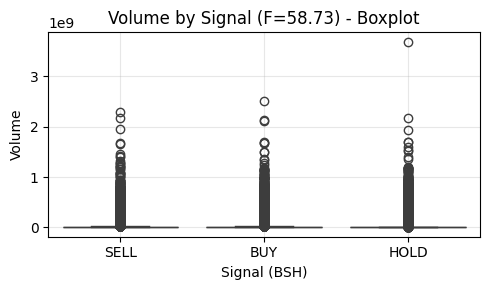

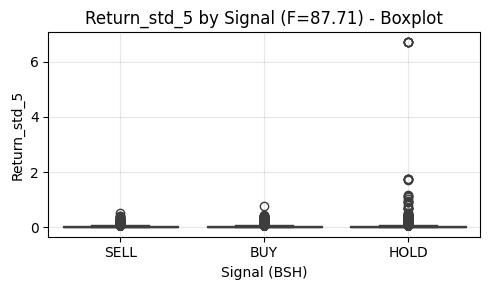

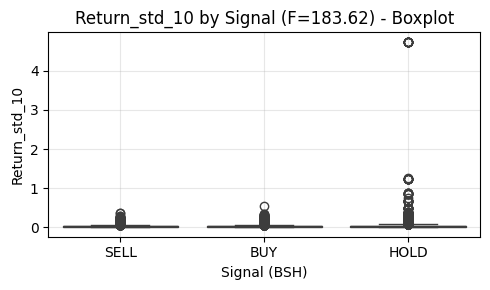

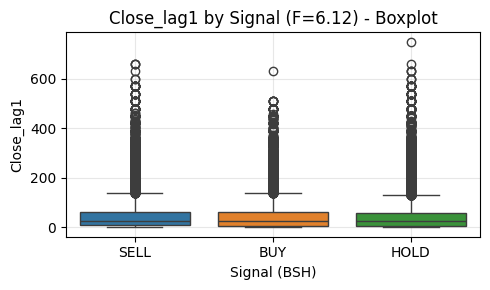

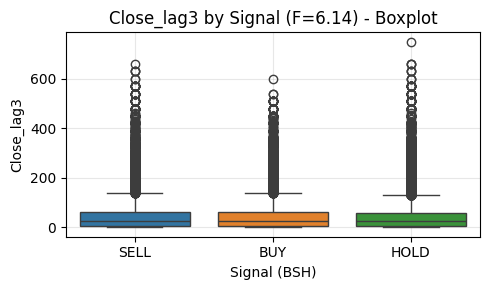

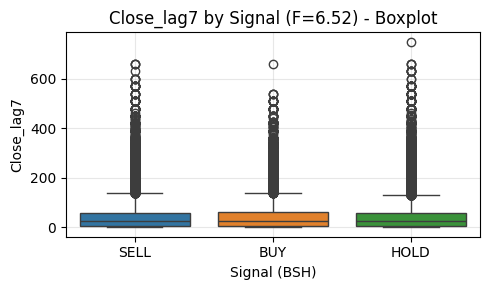

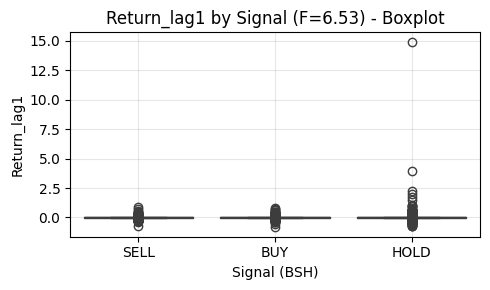

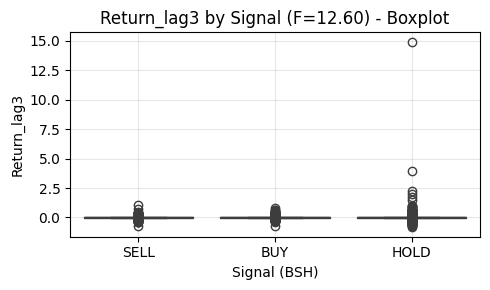

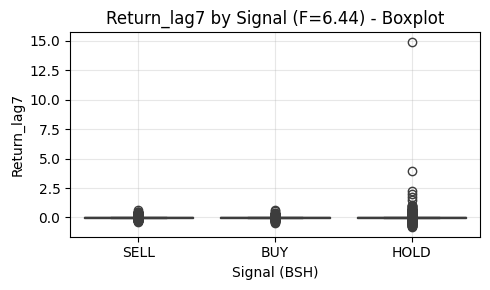

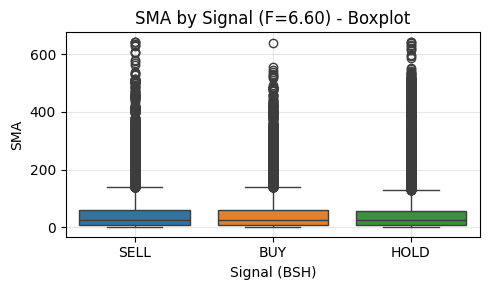

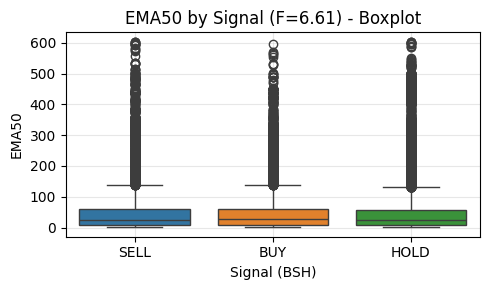

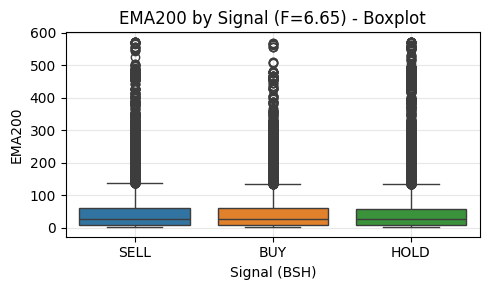

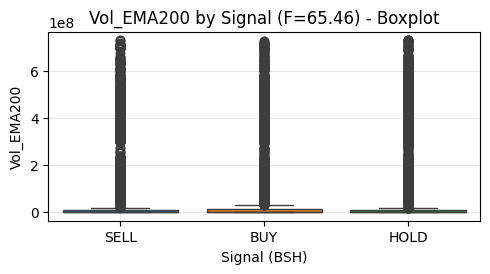

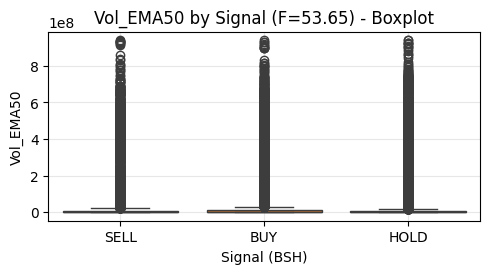

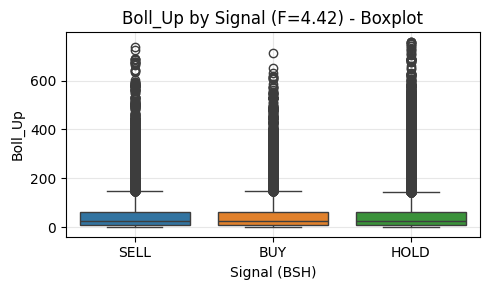

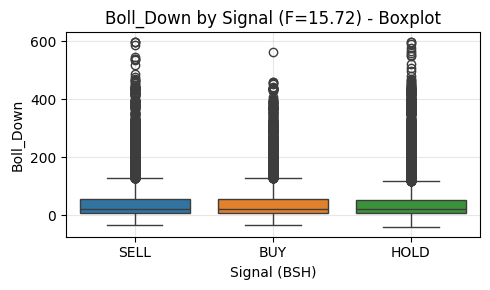

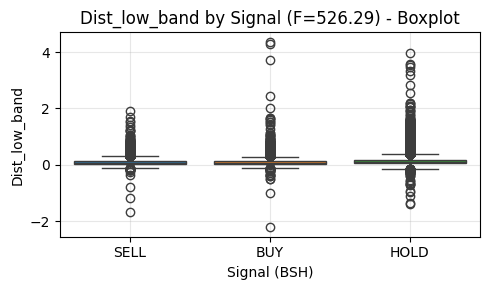

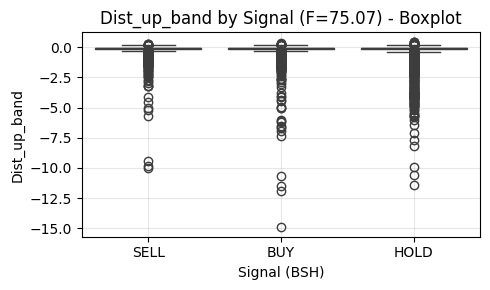

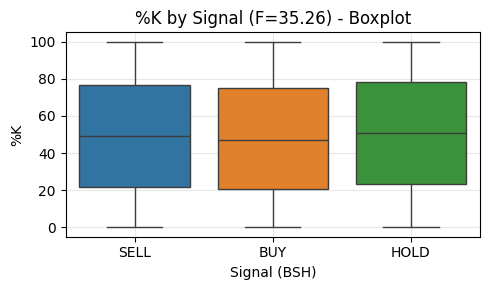

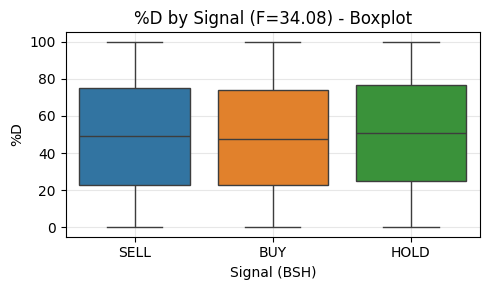

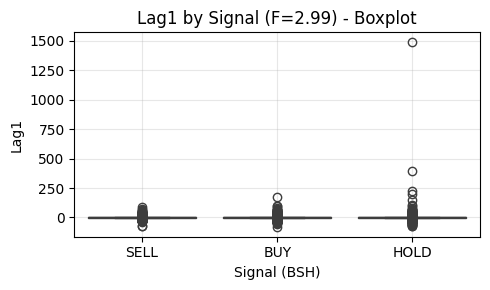

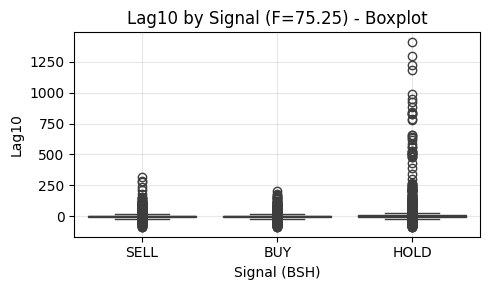

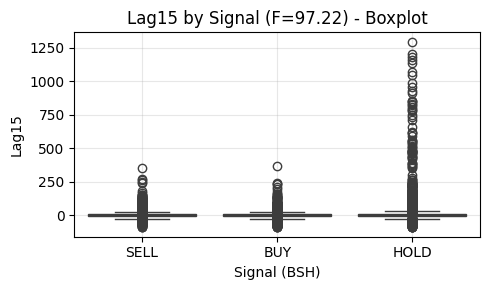

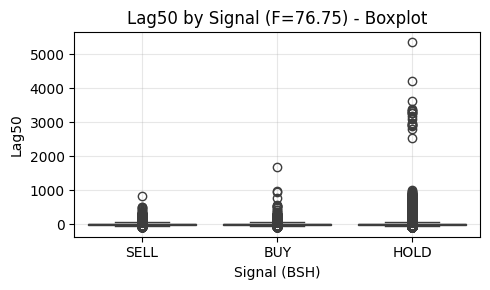

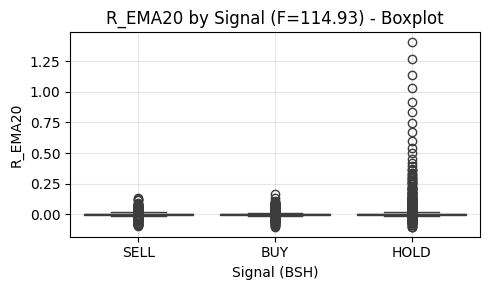

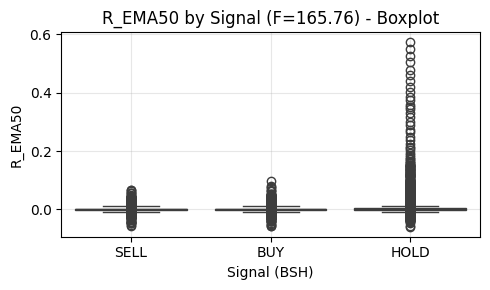

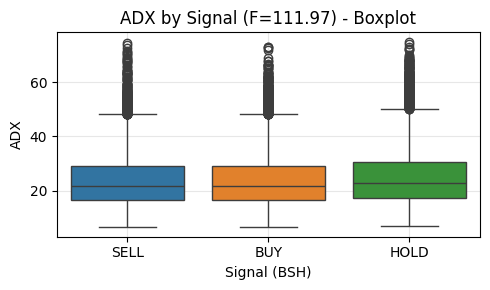

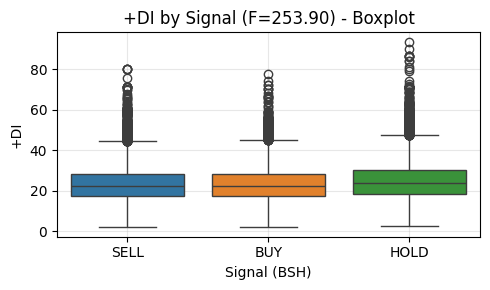

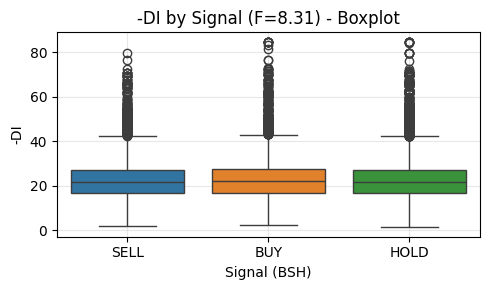

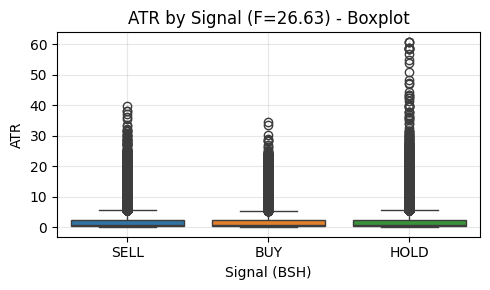

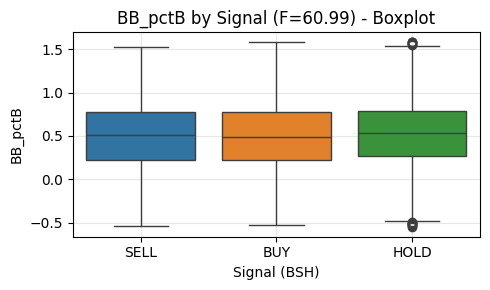

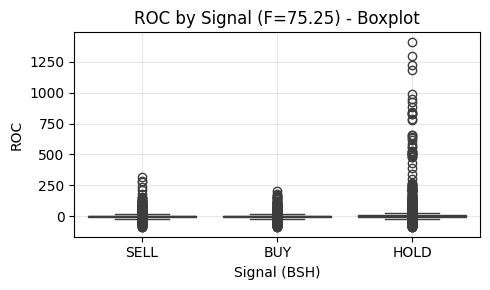

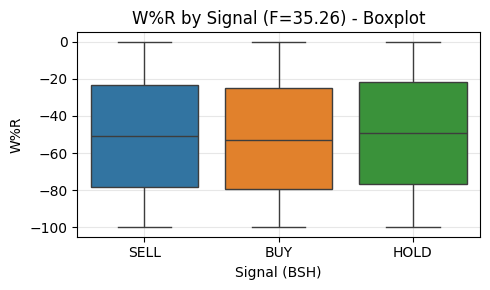

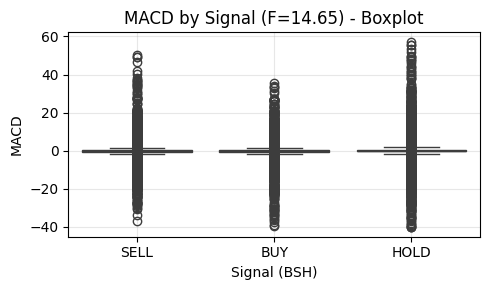

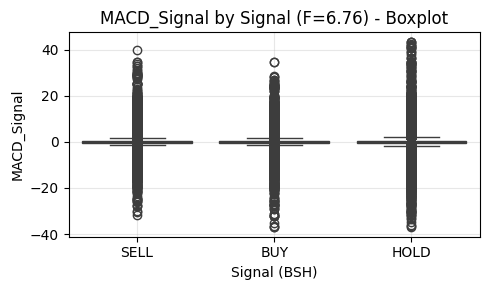

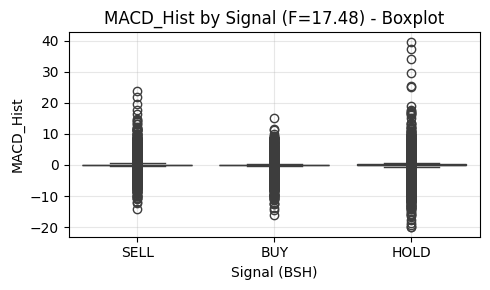

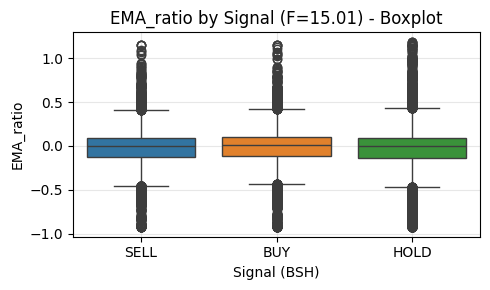

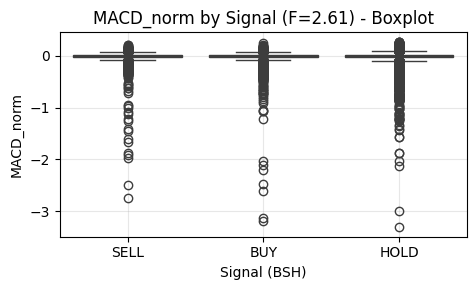

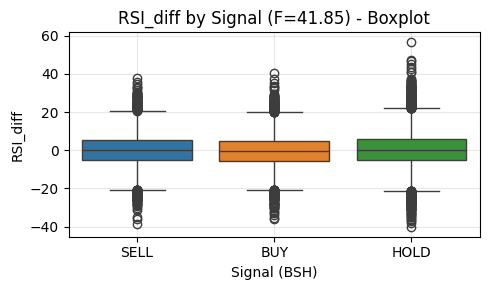

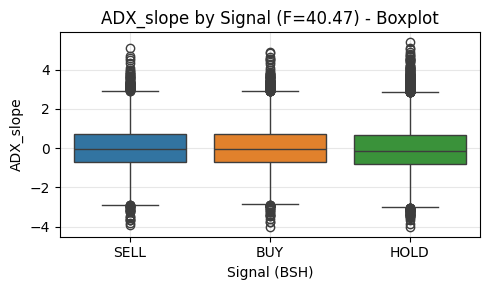

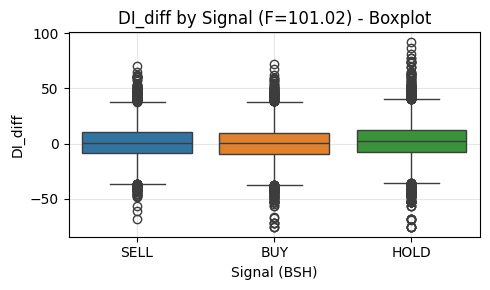

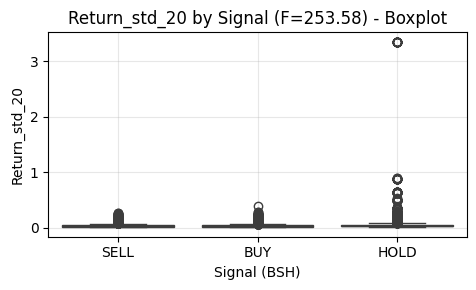

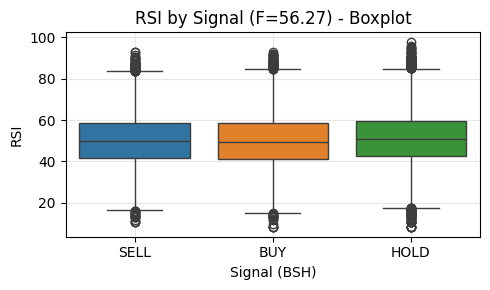

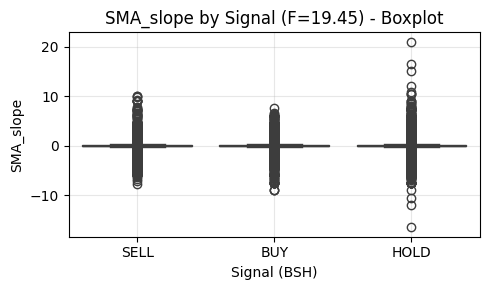

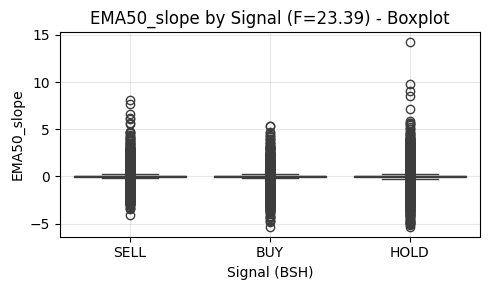

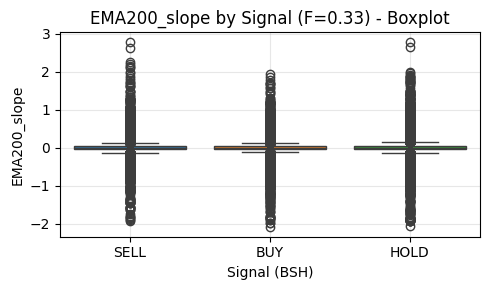

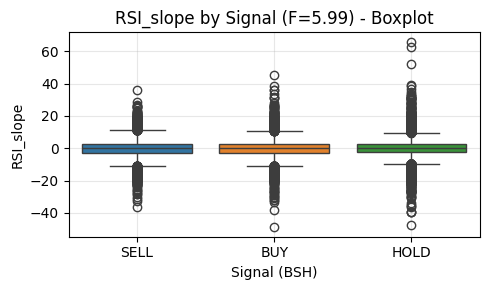

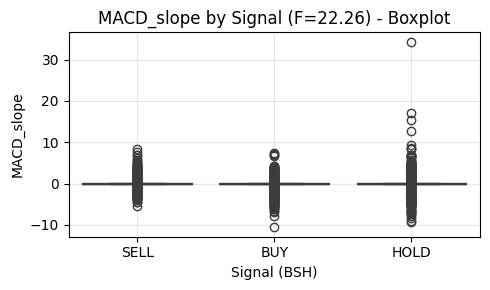

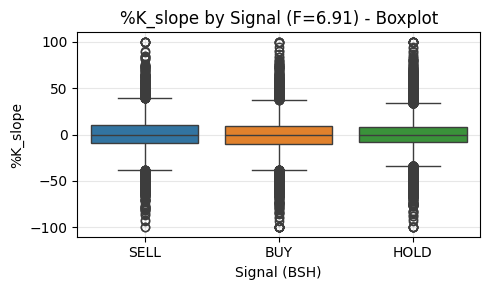

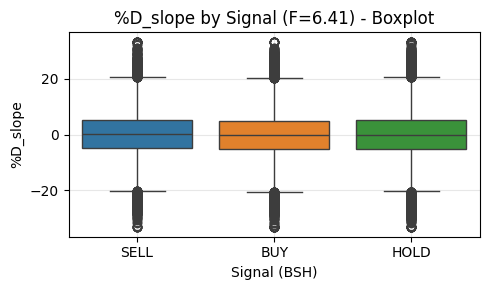

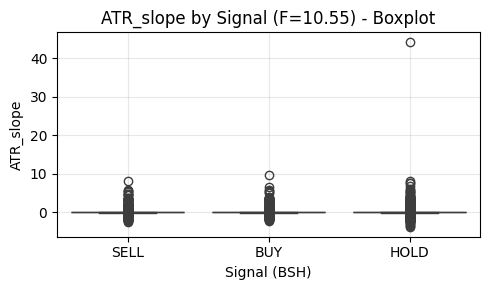

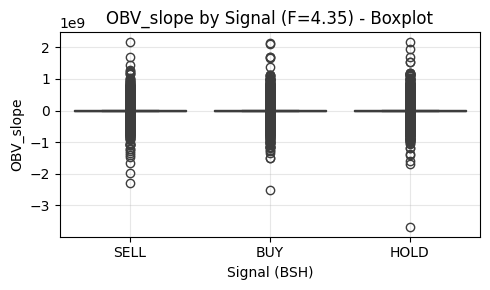

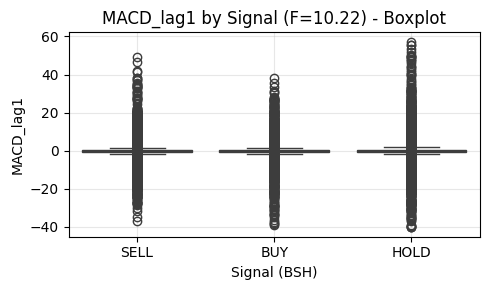

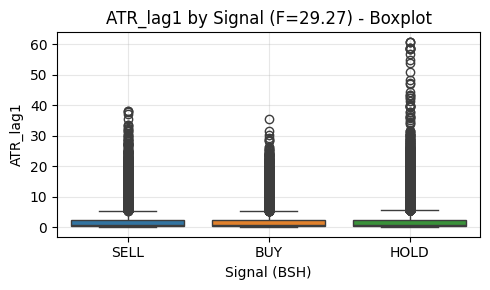

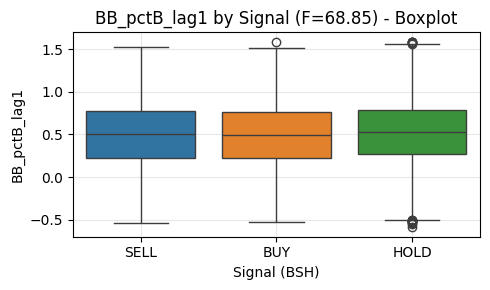

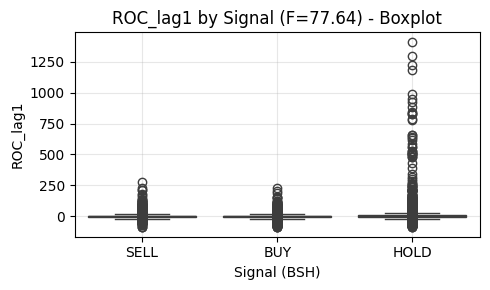

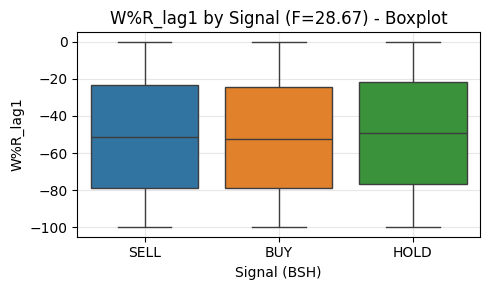

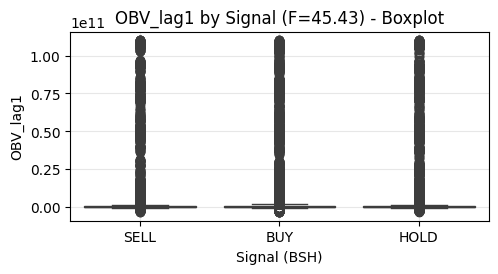

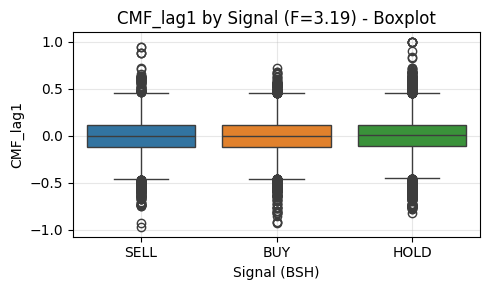

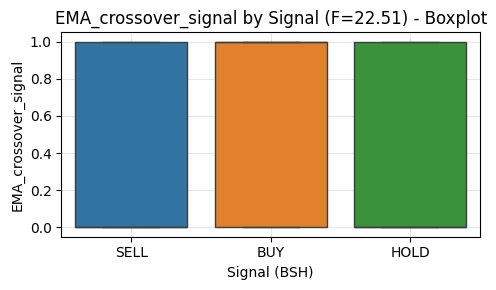

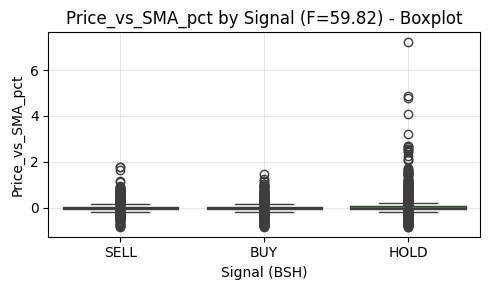

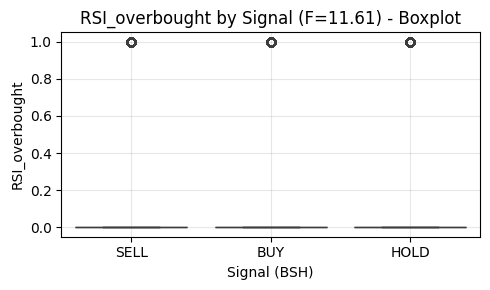

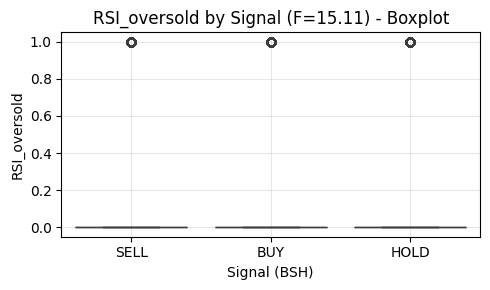

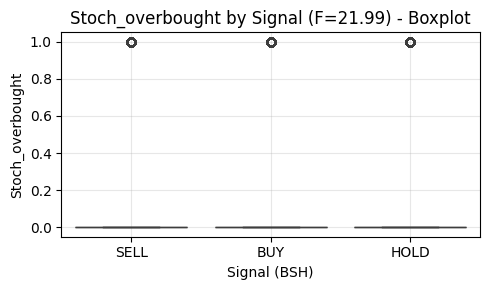

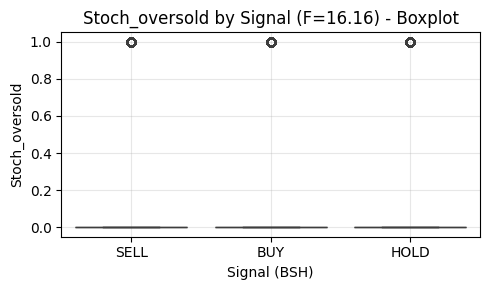

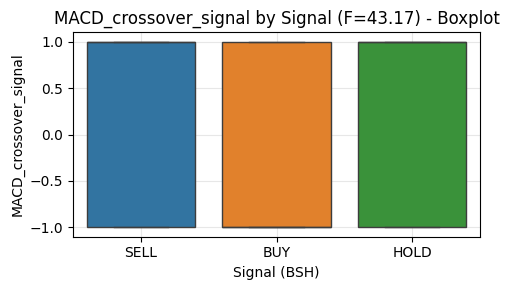

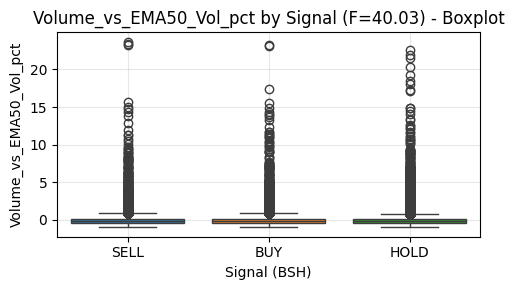

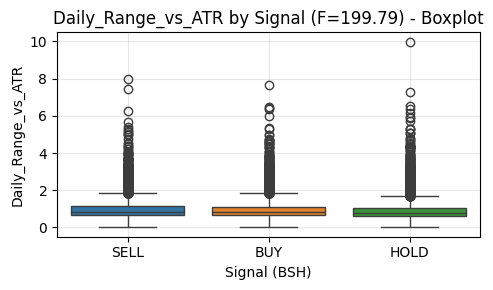

In [4]:
from sklearn.preprocessing import StandardScaler

features = [
    "Volume", "Return_std_5", "Return_std_10", "Close_lag1", "Close_lag3", 
    "Close_lag7", "Return_lag1", "Return_lag3", "Return_lag7", "SMA", 
    "EMA50", "EMA200", "Vol_EMA200", "Vol_EMA50", "Boll_Up", "Boll_Down", 
    "Dist_low_band", "Dist_up_band", "%K", "%D", "Lag1", "Lag10", "Lag15", "Lag50", 
    "R_EMA20","R_EMA50", "ADX", "+DI", "-DI", "ATR", "BB_pctB", "ROC", "W%R", "MACD", 
    "MACD_Signal", "MACD_Hist", "EMA_ratio", "MACD_norm", "RSI_diff",
    "ADX_slope", "DI_diff", "Return_std_20", "RSI",
    "SMA_slope", "EMA50_slope", "EMA200_slope", "RSI_slope", "MACD_slope", 
    "%K_slope", "%D_slope", "ATR_slope", "OBV_slope", 
    "MACD_lag1", "ATR_lag1", "BB_pctB_lag1", "ROC_lag1", "W%R_lag1", 
    "OBV_lag1", "CMF_lag1",
    "EMA_crossover_signal", "Price_vs_SMA_pct", "RSI_overbought", 
    "RSI_oversold", "Stoch_overbought", "Stoch_oversold", 
    "MACD_crossover_signal", "Volume_vs_EMA50_Vol_pct", "Daily_Range_vs_ATR"
]


# --- ANOVA Test sulle feature scelte ---
#L'analisi della varianza (ANOVA, dall'inglese Analysis of Variance) è 
#un insieme di tecniche statistiche che permettono di confrontare 
# due o più gruppi di dati calcolando e confrontando 
#la variabilità interna a questi gruppi con la variabilità tra i gruppi.



#Un valore F elevato indica che la variabilità tra i gruppi è maggiore di quella interna ai gruppi, 
#suggerendo che le differenze tra le medie dei gruppi sono statisticamente significative.
#Cos'è il p-value? Nel test ANOVA si formulano due ipotesi: l'ipotesi nulla, secondo cui tutte le medie dei gruppi
#sarebbero uguali e quella alternativa. Un valore di p < 5% di porta a rifiutare l'ipotesi nulla e a validare quindi l'F-value.

X = df_all[features]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X))
y = df_all[y_label].astype("category").cat.codes  # encode BUY/HOLD/SELL

f_values, p_values = f_classif(X_scaled, y)
separation_df = pd.DataFrame({
    "Feature": features,
    "F_value": f_values,
    "Reliability": ["reliable" if p < 0.005 else "unreliable" for p in p_values]
}).sort_values("F_value", ascending=False)

#top_features = separation_df[separation_df["F_value"] > 25]["Feature"].tolist()


for feat in features:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=y_label, y=feat, data=df_all, hue=y_label,legend=False)
    plt.title(f"{feat} by Signal (F={separation_df.loc[separation_df['Feature']==feat, 'F_value'].values[0]:.2f}) - Boxplot")
    plt.xlabel("Signal (BSH)")
    plt.ylabel(feat)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

#    sns.violinplot(x=y_label, y=feat, data=df_all, hue=y_label,legend=False, inner=None, linewidth=0)
#    plt.title(f"{feat} by Signal (F={separation_df.loc[separation_df['Feature']==feat, 'F_value'].values[0]:.2f}) - Violinplot")
#    plt.xlabel("Signal (BSH)")
#    plt.ylabel(feat)
#    plt.grid(alpha=0.3)
#    plt.tight_layout()
#    plt.show()



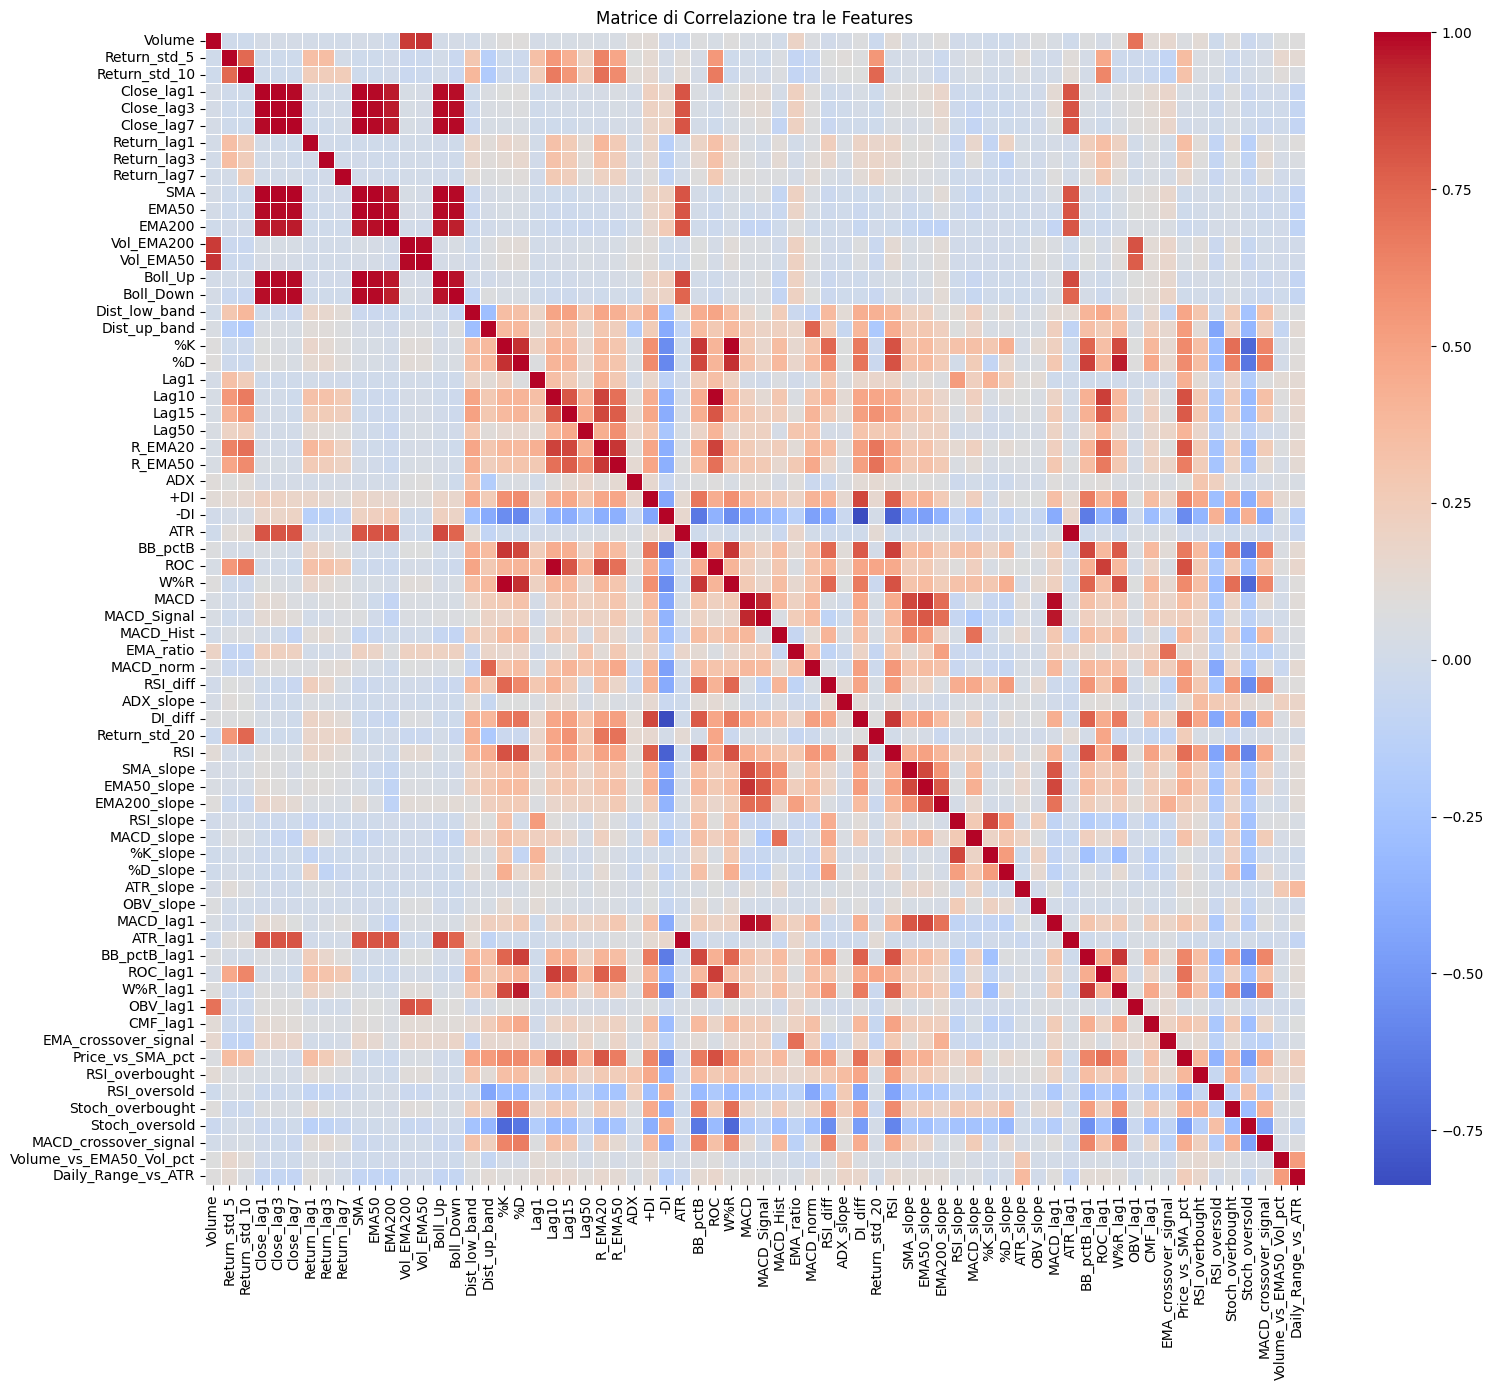


--- Coppie di Feature Altamente Correlate (> 0.9) ---
          Indice_A    Indice_B  Correlation
2129           ROC       Lag10     1.000000
1459         Lag10         ROC     1.000000
1256            %K         W%R     1.000000
2194           W%R          %K     1.000000
617            SMA  Close_lag7     0.996882
...            ...         ...          ...
3728  BB_pctB_lag1    W%R_lag1     0.903054
2058       BB_pctB          %K     0.903035
2072       BB_pctB         W%R     0.903035
1254            %K     BB_pctB     0.903035
2206           W%R     BB_pctB     0.903035

[90 rows x 3 columns]


In [5]:
correlation_matrix = df_all[features].corr()

plt.figure(figsize=(16, 14)) # Rendi la figura grande per leggibilità
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matrice di Correlazione tra le Features")
plt.tight_layout()
plt.show()

# Potresti anche stampare le coppie più correlate
# Crea un DataFrame pulito della matrice di correlazione
corr_df = correlation_matrix.stack().reset_index()
corr_df.columns = ["Indice_A", "Indice_B", "Correlation"]
# Filtra per correlazioni alte (escludendo la correlazione di una feature con se stessa)
high_corr_pairs = corr_df[
    (corr_df["Correlation"].abs() > 0.9) & (corr_df["Indice_A"] != corr_df["Indice_B"])
]
print("\n--- Coppie di Feature Altamente Correlate (> 0.9) ---")
print(high_corr_pairs.sort_values(by="Correlation", ascending=False))


=== Mutual Information Score Ranking ===
          Feature  MI_Score
41  Return_std_20  0.022072
2   Return_std_10  0.019121
15      Boll_Down  0.018086
12     Vol_EMA200  0.017331
16  Dist_low_band  0.015832
..            ...       ...
20           Lag1  0.000034
29            ATR  0.000000
6     Return_lag1  0.000000
38       RSI_diff  0.000000
52      MACD_lag1  0.000000

[68 rows x 2 columns]


/tmp/ipykernel_1976/575073460.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MI_Score", y="Feature", data=mi_df.head(20), palette="viridis")


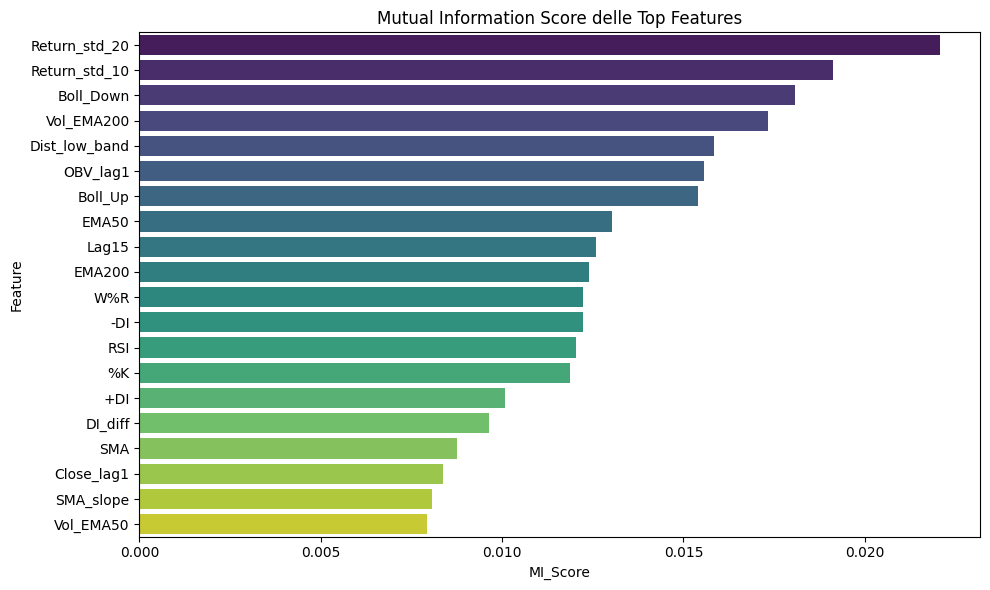

In [6]:
from sklearn.feature_selection import mutual_info_classif

# Mutual Information Score
# Misura la dipendenza tra due variabili. Un valore più alto significa maggiore dipendenza.
# Può catturare relazioni non lineari.

# C'è bisogno che y siano dei numeri. Usiamo y = df_all[y_label].astype("category").cat.codes  da prima

mi_scores = mutual_info_classif(X_scaled, y, random_state=42)
mi_df = pd.DataFrame({
    "Feature": features,
    "MI_Score": mi_scores
}).sort_values("MI_Score", ascending=False)

print("\n=== Mutual Information Score Ranking ===")
print(mi_df)

# Visualizzazione
plt.figure(figsize=(10, 6))
sns.barplot(x="MI_Score", y="Feature", data=mi_df.head(20), palette="viridis")
plt.title("Mutual Information Score delle Top Features")
plt.tight_layout()
plt.show()

In [ ]:
# --- Features e target ---

top_features = mi_df["Feature"].head(20).tolist()

X = df_all[top_features]
y = df_all[y_label]

# Split temporale train/test
X.index = pd.to_datetime(X.index)

cutoff = pd.to_datetime("2023-01-01")
train_mask = X.index < cutoff
test_mask = X.index >= cutoff

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]


bsh_counts = y_test.value_counts()
print(f"  Conteggio etichette per il test:")
print(bsh_counts)
print(f"  Totale righe: {len(y_test)}")
print("-" * 40)

  Conteggio etichette per il test:
BSH
HOLD    8636
BUY     5534
SELL    5198
Name: count, dtype: int64
  Totale righe: 19368
----------------------------------------


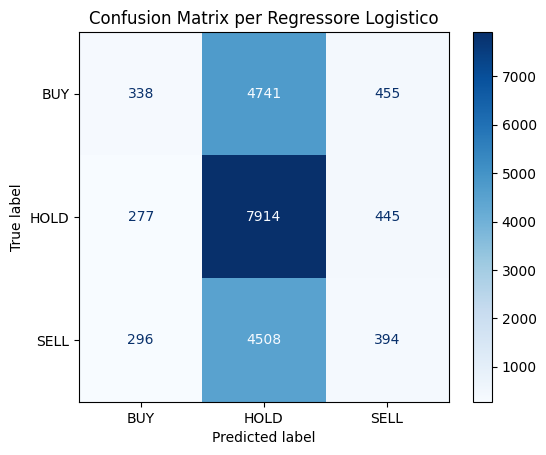

Classification report per Regressione Logistica:
              precision    recall  f1-score   support

         BUY       0.37      0.06      0.10      5534
        HOLD       0.46      0.92      0.61      8636
        SELL       0.30      0.08      0.12      5198

    accuracy                           0.45     19368
   macro avg       0.38      0.35      0.28     19368
weighted avg       0.39      0.45      0.34     19368



In [ ]:
from sklearn.linear_model import LogisticRegression

# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

softmax_reg = LogisticRegression(max_iter=2000,solver="lbfgs",random_state=42)

softmax_reg.fit(X_train_scaled, y_train)

# Predizioni
y_pred = softmax_reg.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred, labels=["BUY", "HOLD", "SELL"])
    

# Report di classificazione
print("Classification report per Regressione Logistica:")
print(classification_report(y_test, y_pred, labels=["BUY","HOLD","SELL"]))


Testing degli iperparametri su Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [8, 12, 16, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",  
    cv=5,                
    n_jobs=-1,            
    verbose=2
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Cross-val scores (RF):
[0.33990796 0.32960771 0.37300022 0.38045146 0.34757835 0.33596318
 0.35050416 0.38689171 0.37724682 0.40968873]


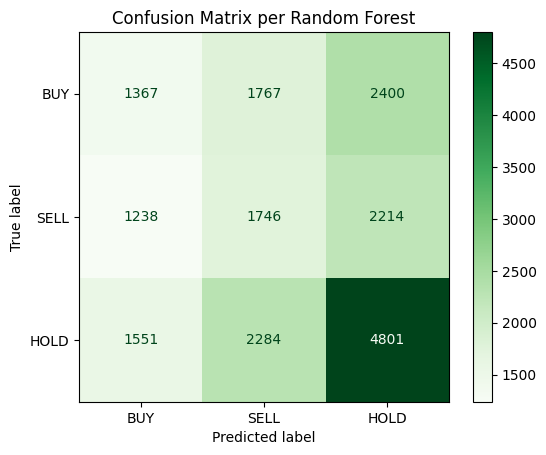

Classification report (Random Forest):
              precision    recall  f1-score   support

         BUY       0.33      0.25      0.28      5534
        SELL       0.30      0.34      0.32      5198
        HOLD       0.51      0.56      0.53      8636

    accuracy                           0.41     19368
   macro avg       0.38      0.38      0.38     19368
weighted avg       0.40      0.41      0.40     19368



In [20]:
# --- Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,      
    max_depth=None,        
    random_state=42,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1
)

print("Cross-val scores (RF):")
print(cross_val_score(rf, X_train, y_train, cv=10, scoring="accuracy"))

rf.fit(X_train, y_train)

# Predizioni
y_pred_rf = rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["BUY","SELL","HOLD"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["BUY","SELL","HOLD"])
disp_rf.plot(cmap="Greens")
plt.title("Confusion Matrix per Random Forest")
plt.show()

# Report di classificazione
print("Classification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, labels=["BUY","SELL","HOLD"]))

In [28]:
features = top_features
X = df_all[features].copy()
y = df_all[y_label].copy()

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]


tscv = TimeSeriesSplit(n_splits=5)

# LGBM with basic params
lgb_clf = LGBMClassifier(objective="multiclass",num_class=3, random_state=42, n_jobs=-1, class_weight="balanced")

param_dist = {
    "n_estimators": [200, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [15, 31, 63],
    "min_child_samples": [10, 20, 50],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 1.0],
    "reg_lambda": [0.0, 0.1, 1.0],
}

scorer = make_scorer(f1_score, average="macro")

rand = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=40,
    scoring=scorer,
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rand.fit(X_train, y_train)
print("Best params:", rand.best_params_)
print("Best CV f1_macro:", rand.best_score_)
best = rand.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8771, number of used features: 20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8771, number of used features: 20
[LightGBM] [Info] Number of data points in the train set: 17542, number of used features: 20
[LightGBM] [Info] S

/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 35084, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[CV] END colsample_bytree=1.0, learning_rate=0.05, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=65.6min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 43855, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[CV] END colsample_bytree=1.0, learning_rate=0.05, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=65.9min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8771, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[CV] END colsample_bytree=1.0, learning_rate=0.05, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=67.6min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 17542, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[CV] END colsample_bytree=1.0, learning_rate=0.05, min_child_samples=20, n_estimators=200, num_leaves=31, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=67.9min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 26313, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[CV] END colsample_bytree=0.6, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=31, reg_alpha=1.0, reg_lambda=0.1, subsample=1.0; total time=164.8min


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 35084, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[CV] END colsample_bytree=0.6, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=31, reg_alpha=1.0, reg_lambda=0.1, subsample=1.0; total time=167.6min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 43855, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[CV] END colsample_bytree=0.6, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=31, reg_alpha=1.0, reg_lambda=0.1, subsample=1.0; total time=167.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8771, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[CV] END colsample_bytree=0.6, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=31, reg_alpha=1.0, reg_lambda=0.1, subsample=1.0; total time=168.9min


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.315471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 17542, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[CV] END colsample_bytree=0.6, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=31, reg_alpha=1.0, reg_lambda=0.1, subsample=1.0; total time=169.6min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 26313, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[CV] END colsample_bytree=1.0, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=31, reg_alpha=0.1, reg_lambda=1.0, subsample=0.6; total time=162.9min


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 35084, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[CV] END colsample_bytree=1.0, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=15, reg_alpha=0.0, reg_lambda=1.0, subsample=0.8; total time=79.8min


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 43855, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[CV] END colsample_bytree=1.0, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=15, reg_alpha=0.0, reg_lambda=1.0, subsample=0.8; total time=81.3min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8771, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[CV] END colsample_bytree=1.0, learning_rate=0.05, min_child_samples=10, n_estimators=500, num_leaves=15, reg_alpha=0.0, reg_lambda=1.0, subsample=0.8; total time=82.1min


/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samu/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/samu/Ma

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 17542, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


KeyboardInterrupt: 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 45626, number of used features: 20
[LightGBM] [Info] Start training from score -1.234746
[LightGBM] [Info] Start training from score -0.827800
[LightGBM] [Info] Start training from score -1.301653


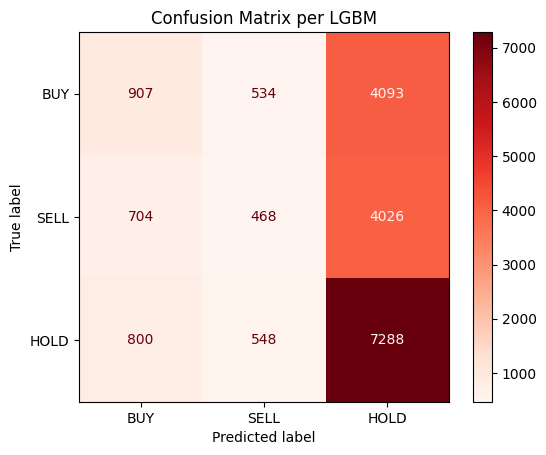

Classification Report per LGBM:
              precision    recall  f1-score   support

         BUY       0.38      0.16      0.23      5534
        HOLD       0.47      0.84      0.61      8636
        SELL       0.30      0.09      0.14      5198

    accuracy                           0.45     19368
   macro avg       0.38      0.37      0.32     19368
weighted avg       0.40      0.45      0.37     19368



In [8]:
from lightgbm import LGBMClassifier

# --- LGBM ---
lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,  
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)


y_pred = lgbm.predict(X_test)


# Confusion matrix
cm_rf = confusion_matrix(y_test, np.asarray(y_pred), labels=["BUY","SELL","HOLD"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["BUY","SELL","HOLD"])
disp_rf.plot(cmap="Reds")
plt.title("Confusion Matrix per LGBM")
plt.show()


print("Classification Report per LGBM:")
print(classification_report(y_test, np.asarray(y_pred)))

In [ ]:
# Export model code
import joblib

SavedName = f"rf_{TICKER}_v1.joblib"

# Selezionare la variabile del modello da estrarre
bundle = {
    "model": rf,
    # add scaler if needed "scaler": scaler
    "features": features 
}
#joblib.dump(bundle, f"models/{SavedName}")

